In [1]:
from collections import deque
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
class Interpolator(BaseEstimator, TransformerMixin):
    def __init__(self, freq: str):
        self.freq = freq
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if the passed Dataframe has the corrct format
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expecting a pandas DataFrame")
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index should be a DatetimeIndex")
        
        # Calculate Timestamps for the given Frequency
        start_date = X.index.min().floor(self.freq)
        end_date = X.index.max()
        all_hours = pd.date_range(start=start_date, end=end_date, freq=self.freq)
        
        # Combine the given Data with the generated Timestamps
        hourly_df = pd.DataFrame(index=all_hours)
        combined_df = pd.concat([X, hourly_df], axis=0).sort_index()
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        
        # Interpolate the Data
        combined_df = combined_df.interpolate(method='linear', limit_direction='both')
        
        # Keep only generated Timestamps
        interpolated_df = combined_df[combined_df.index.floor('30min') == combined_df.index]
        
        return interpolated_df

In [3]:
class RollingMeanFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_size: int):
        self.window_size = window_size
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rolling(window=self.window_size, center=True, min_periods=1, win_type='gaussian').mean(std=1)

In [4]:
class TrigonometryFeatureEnricher(BaseEstimator, TransformerMixin):
    def __init__(self, day=True, week=True, month=True, year=True):
        self.day = day
        self.week = week
        self.month = month
        self.year = year
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ensure X is a DataFrame and has a DateTimeIndex
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("DataFrame must have a DateTimeIndex")

        # Calculate continuous time values for daily and weekly cycles
        hours_in_day = X.index.hour + X.index.minute / 60 + X.index.second / 3600
        days_in_week = X.index.dayofweek + hours_in_day / 24
        days_in_month = X.index.day + hours_in_day / 24
        months_in_year = X.index.month + X.index.day / 30.44

        if self.day:
            X['sin_day'] = np.sin(2 * np.pi * hours_in_day / 24)
            X['cos_day'] = np.cos(2 * np.pi * hours_in_day / 24)
        if self.week:
            X['sin_week'] = np.sin(2 * np.pi * days_in_week / 7)
            X['cos_week'] = np.cos(2 * np.pi * days_in_week / 7)
        if self.month:
            X['sin_month'] = np.sin(2 * np.pi * days_in_month / 30.44)
            X['cos_month'] = np.cos(2 * np.pi * days_in_month / 30.44)
        if self.year:
            X['sin_year'] = np.sin(2 * np.pi * months_in_year / 12)
            X['cos_year'] = np.cos(2 * np.pi * months_in_year / 12)
        
        return X

In [5]:
class ColumnShifter(BaseEstimator, TransformerMixin):
    def __init__(self, shift: int):
        self.shift = shift
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        for column in X.columns:
            shifted_column_name = f'{column}_shift_{self.shift}'
            X[shifted_column_name] = X[column].shift(self.shift)
            
        return X[:self.shift]

In [6]:
class IncompleteDayDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.start_date = None
        self.end_date = None
    
    def fit(self, X, y=None):
        self.start_date = X.index.min()
        self.end_date = X.index.max()
        
        return self
        
    def transform(self, X):
        X_filtered = X.copy()

        if not (self.start_date.hour == 0 and self.start_date.minute == 0):
            X_filtered = X_filtered[X_filtered.index.date != self.start_date.date()]
        
        if not (self.end_date.hour == 23 and self.end_date.minute == 30):
            X_filtered = X_filtered[X_filtered.index.date != self.end_date.date()]
        
        return X_filtered

In [7]:
db_user = 'postgres'
db_password = 'password'
db_host = 'localhost'
db_port = '5432'
db_name = 'gas_station'

connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

engine = create_engine(connection_string)

In [8]:
query = 'SELECT date, e5 FROM omv ORDER BY date'

df = pd.read_sql(query, engine)
df['e5'] /= 1000
df.set_index('date', inplace=True)
df.head()

,e5
date,
2023-01-01 04:40:09+00:00,1.659
2023-01-01 05:32:08+00:00,1.929
2023-01-01 06:33:08+00:00,1.679
2023-01-01 06:40:10+00:00,1.659
2023-01-01 11:24:09+00:00,1.709


In [9]:
train, test, _, _ = train_test_split(df, df, shuffle=False, test_size=0.15)

train.shape, test.shape

((14512, 1), (2561, 1))

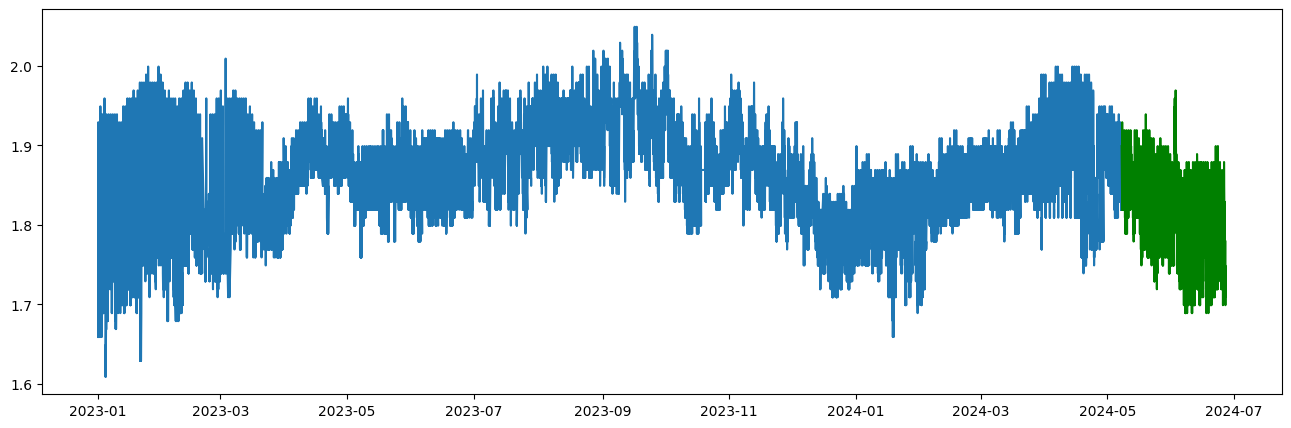

In [10]:
plt.figure(figsize=(16, 5))

plt.plot(train)
plt.plot(test, 'g')

plt.show()

In [11]:
pipe = Pipeline([
    ('interpolate', Interpolator(freq='30min')),
    ('rolling_mean', RollingMeanFilter(window_size=3)),
    ('drop_incomplete_day', IncompleteDayDropper()),
    ('column_shifter', ColumnShifter(shift=-48)),
    ('trigonomy_feature', TrigonometryFeatureEnricher(day=True, week=True, month=True, year=True))
])
pipe

Pipeline(steps=[('interpolate', Interpolator(freq='30min')),
                ('rolling_mean', RollingMeanFilter(window_size=3)),
                ('drop_incomplete_day', IncompleteDayDropper()),
                ('column_shifter', ColumnShifter(shift=-48)),
                ('trigonomy_feature', TrigonometryFeatureEnricher())])

In [12]:
preprocessed_train_df = pipe.fit_transform(train)

preprocessed_train_df

,e5,e5_shift_-48,sin_day,cos_day,sin_week,cos_week,sin_month,cos_month,sin_year,cos_year
2023-01-02 00:00:00+00:00,1.709000,1.714000,0.000000,1.000000,0.000000,1.000000,0.401198,0.915991,0.529491,0.848315
2023-01-02 00:30:00+00:00,1.704000,1.711500,0.130526,0.991445,0.018699,0.999825,0.405133,0.914258,0.529491,0.848315
2023-01-02 01:00:00+00:00,1.699000,1.709000,0.258819,0.965926,0.037391,0.999301,0.409061,0.912507,0.529491,0.848315
2023-01-02 01:30:00+00:00,1.694000,1.706500,0.382683,0.923880,0.056070,0.998427,0.412981,0.910740,0.529491,0.848315
2023-01-02 02:00:00+00:00,1.689000,1.704000,0.500000,0.866025,0.074730,0.997204,0.416894,0.908955,0.529491,0.848315
...,...,...,...,...,...,...,...,...,...,...
2024-05-05 21:30:00+00:00,1.877365,1.898615,-0.608761,0.793353,-0.093364,0.995632,0.938054,0.346488,0.423761,-0.905774
2024-05-05 22:00:00+00:00,1.876692,1.902846,-0.500000,0.866025,-0.074730,0.997204,0.939536,0.342451,0.423761,-0.905774
2024-05-05 22:30:00+00:00,1.870538,1.899769,-0.382683,0.923880,-0.056070,0.998427,0.941000,0.338408,0.423761,-0.905774
2024-05-05 23:00:00+00:00,1.864385,1.896692,-0.258819,0.965926,-0.037391,0.999301,0.942446,0.334358,0.423761,-0.905774


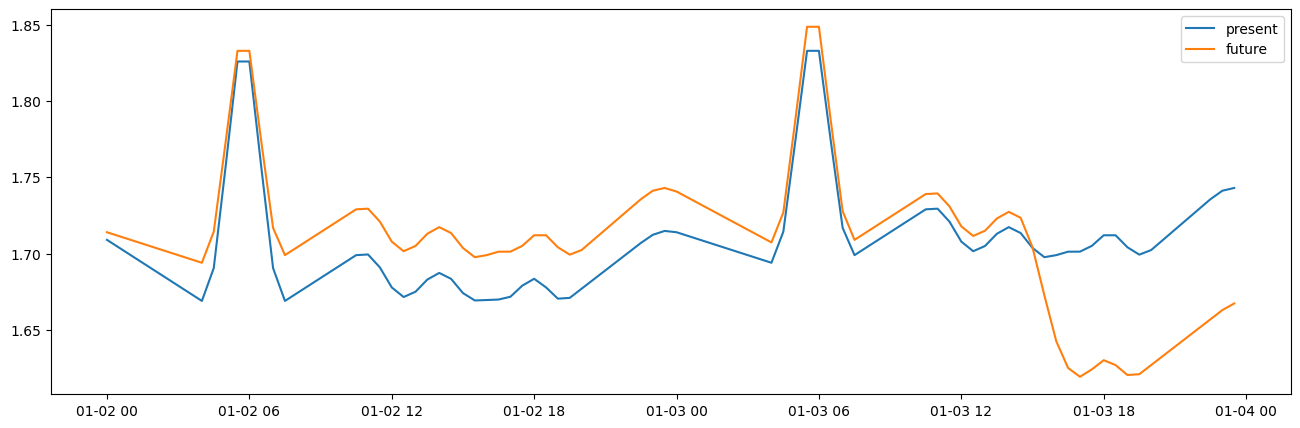

In [13]:
plt.figure(figsize=(16, 5))

plt.plot(preprocessed_train_df['e5']['2023-01-01':'2023-01-03'], label='present')
plt.plot(preprocessed_train_df['e5_shift_-48']['2023-01-01':'2023-01-03'], label='future')

plt.legend()

plt.show()

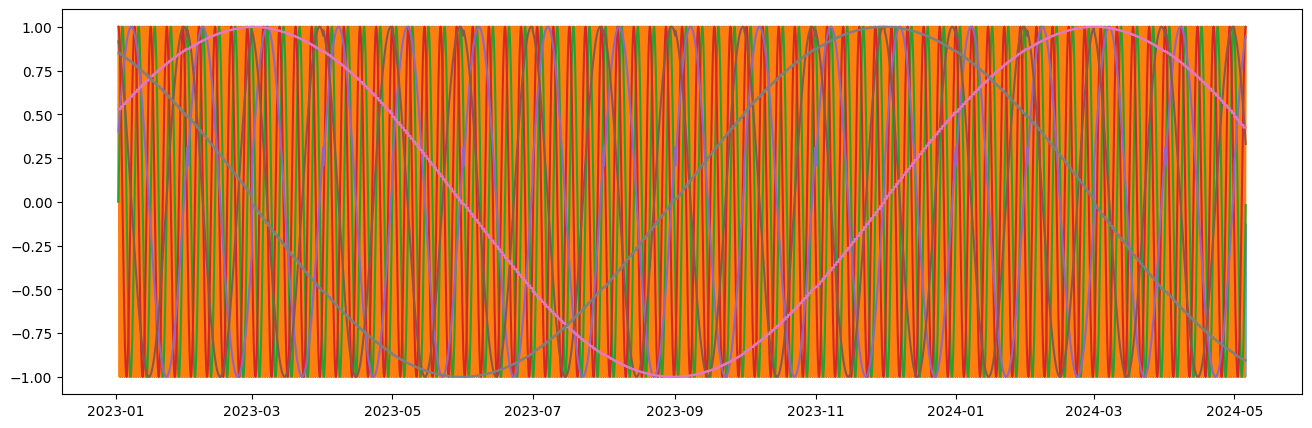

In [14]:
plt.figure(figsize=(16, 5))

plt.plot(preprocessed_train_df['sin_day'])
plt.plot(preprocessed_train_df['cos_day'])
plt.plot(preprocessed_train_df['sin_week'])
plt.plot(preprocessed_train_df['cos_week'])
plt.plot(preprocessed_train_df['sin_month'])
plt.plot(preprocessed_train_df['cos_month'])
plt.plot(preprocessed_train_df['sin_year'])
plt.plot(preprocessed_train_df['cos_year'])

plt.show()

In [15]:
X_train = preprocessed_train_df.drop(columns=['e5_shift_-48'])
y_train = preprocessed_train_df['e5_shift_-48']

In [16]:
def split_data(X: pd.DataFrame, y: pd.Series):
    X_splitted_data = deque()
    y_splitted_data = deque()
    
    min_date = X.index.min()
    max_date = X.index.max()
    
    all_days = pd.date_range(start=min_date, end=max_date, freq='1d')
    for day in all_days:
        X_splitted_data.append(X[X.index.date == day.date()].to_numpy())
        y_splitted_data.append(y[y.index.date == day.date()].to_numpy())
        
    return np.array(X_splitted_data), np.array(y_splitted_data)

In [17]:
X_train_splitted_data, y_train_splitted_data = split_data(X_train, y_train)

X_train_splitted_data.shape, y_train_splitted_data.shape

((490, 48, 9), (490, 48))

In [18]:
preprocessed_test_df = pipe.fit_transform(test)
X_test = preprocessed_test_df.drop(columns=['e5_shift_-48'])
y_test = preprocessed_test_df['e5_shift_-48']
X_test_splitted_data, y_test_splitted_data = split_data(X_test, y_test)

X_test_splitted_data.shape, y_test_splitted_data.shape

((48, 48, 9), (48, 48))

In [19]:
model = Sequential([
    Input(shape=(X_train_splitted_data.shape[1], X_train_splitted_data.shape[2])),
    LSTM(units=32, activation='relu', return_sequences=True),
    LSTM(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=48)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 32)         │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         3,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,088 (90.19 KB)

 Trainable params: 23,088 (90.19 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_splitted_data, y_train_splitted_data, epochs=100, batch_size=16, verbose=True, validation_data=(X_test_splitted_data, y_test_splitted_data), callbacks=[early_stopping])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 2.9959 - mae: 1.6979 - val_loss: 0.3995 - val_mae: 0.5337
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3600 - mae: 0.4688 - val_loss: 0.0340 - val_mae: 0.1485
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0393 - mae: 0.1543 - val_loss: 0.0202 - val_mae: 0.1122
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0139 - mae: 0.0930 - val_loss: 0.0134 - val_mae: 0.0918
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0091 - mae: 0.0754 - val_loss: 0.0091 - val_mae: 0.0752
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0061 - mae: 0.0620 - val_loss: 0.0108 - val_mae: 0.0837
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0047 - mae: 0.0545 - val_loss: 0.0069 - val_mae: 0.0659
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0038 - mae: 0.0491 - val_loss: 0.0065 - val_mae: 0.0646
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

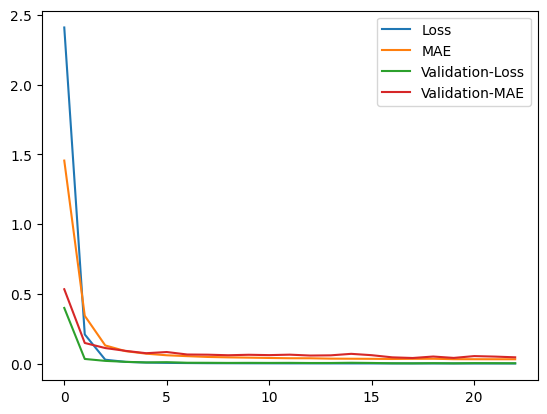

In [21]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_loss'], label='Validation-Loss')
plt.plot(history.history['val_mae'], label='Validation-MAE')

plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


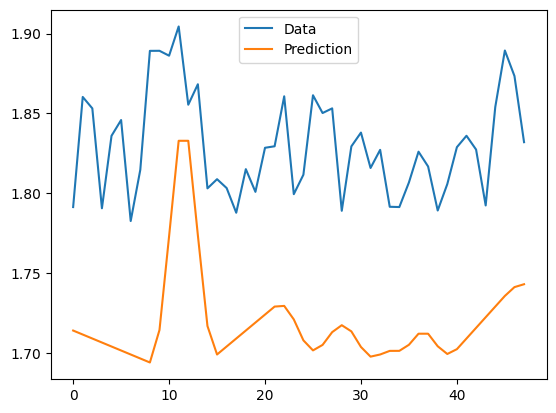

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


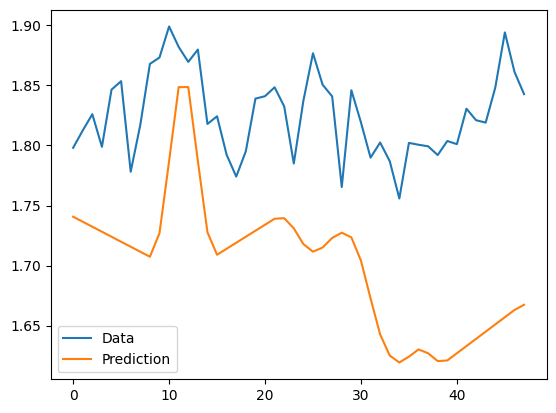

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


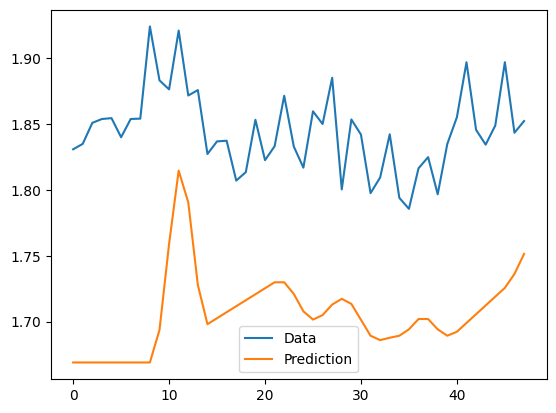

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


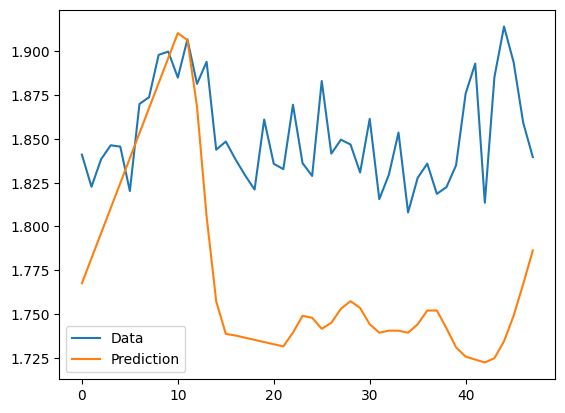

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


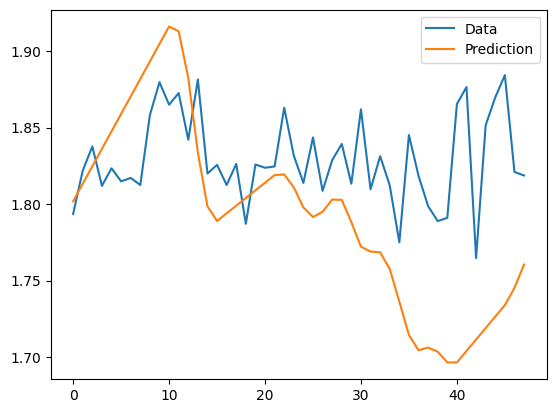

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


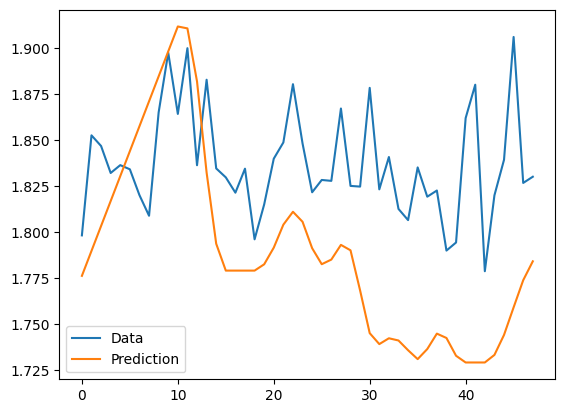

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


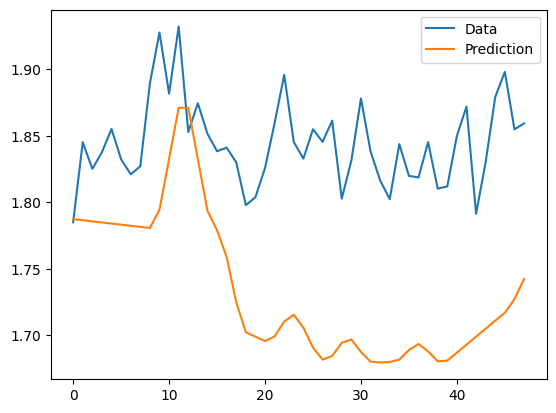

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


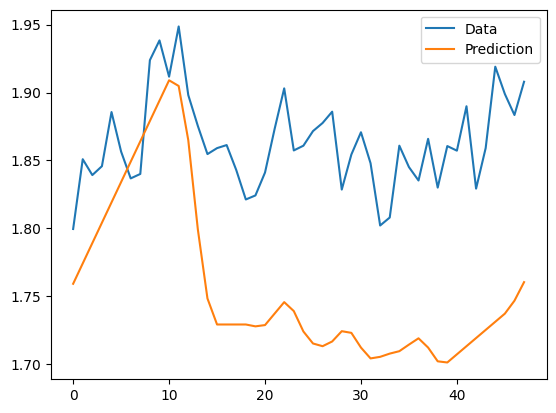

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


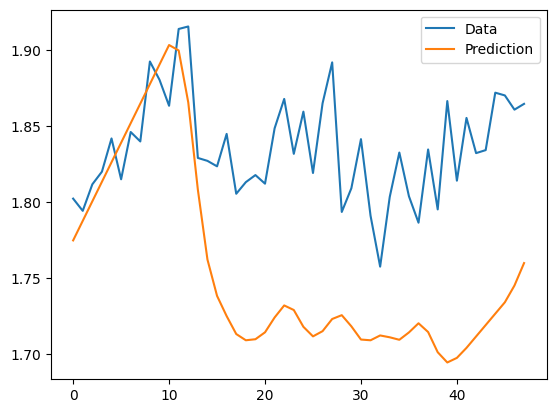

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


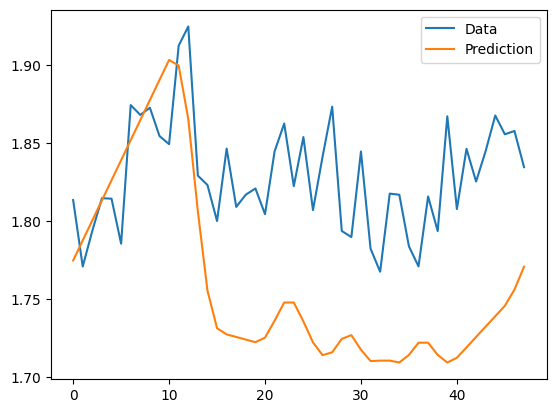

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


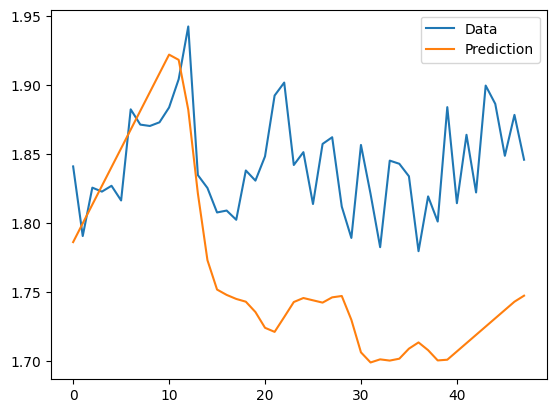

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


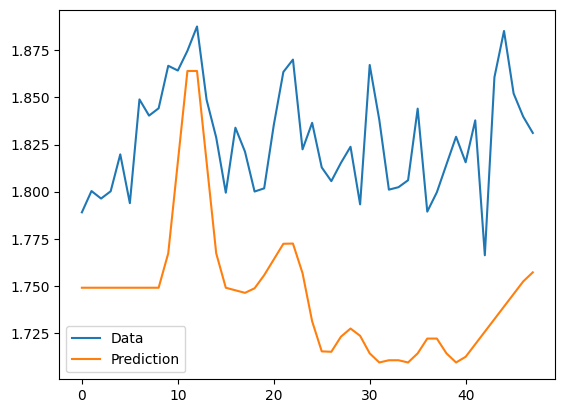

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


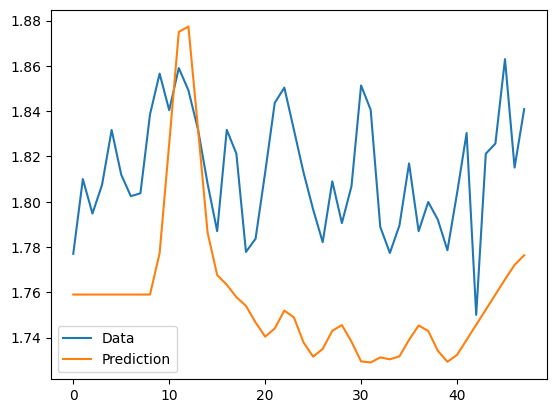

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


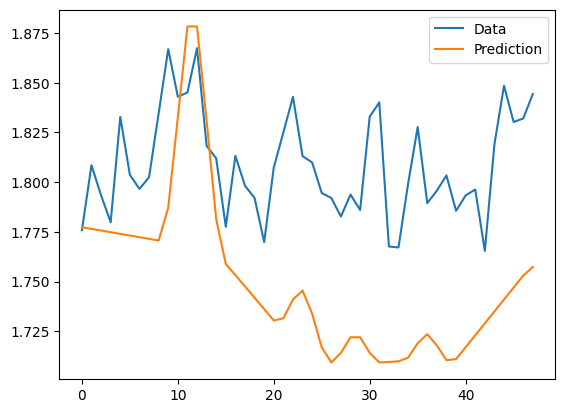

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


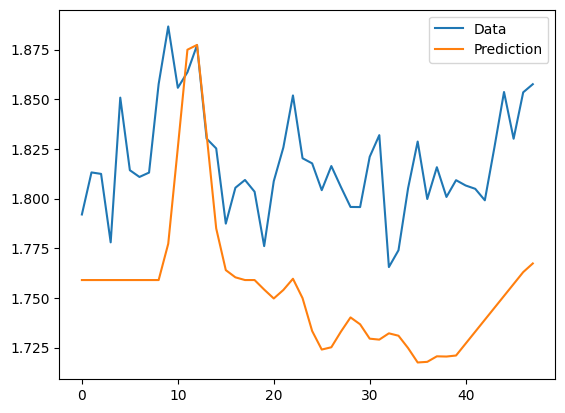

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


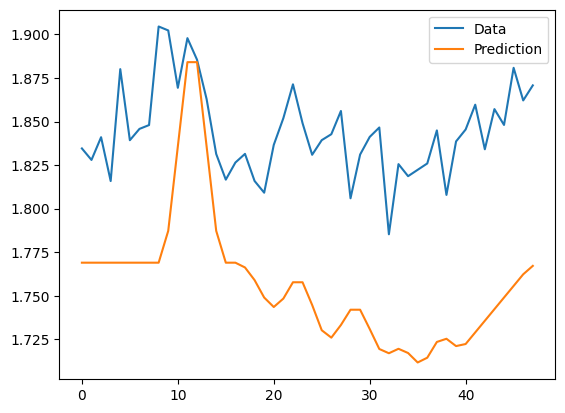

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


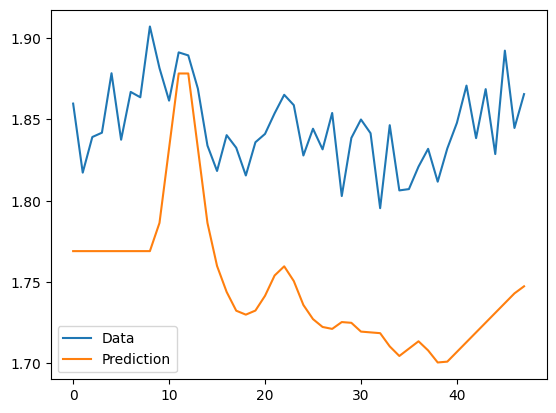

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


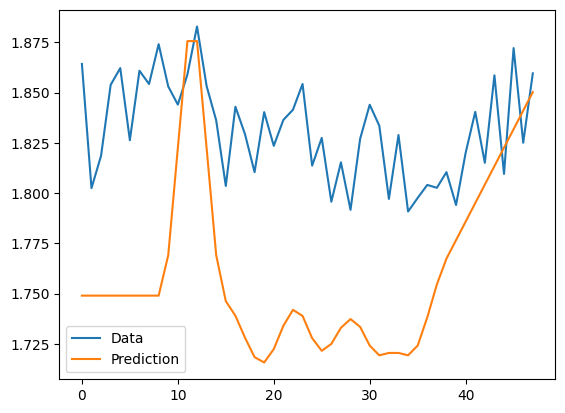

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


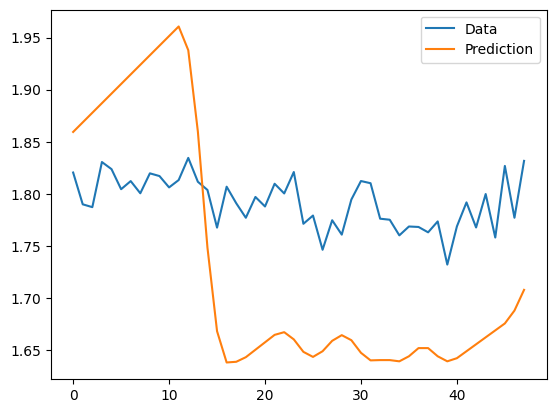

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


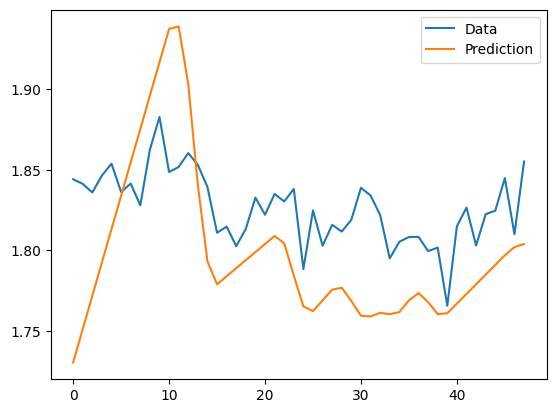

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


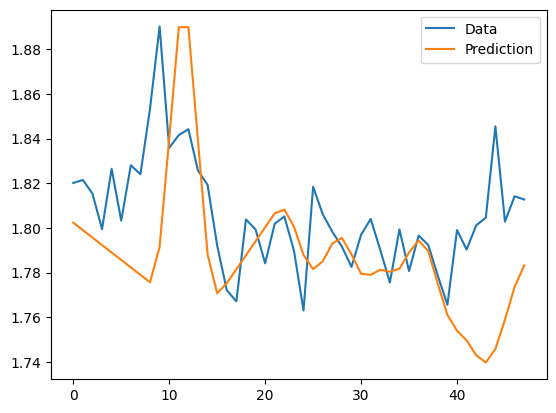

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


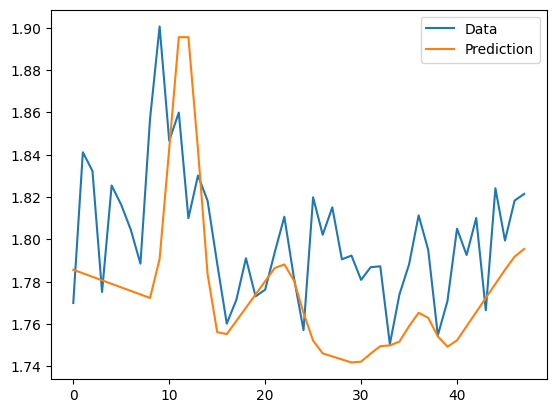

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


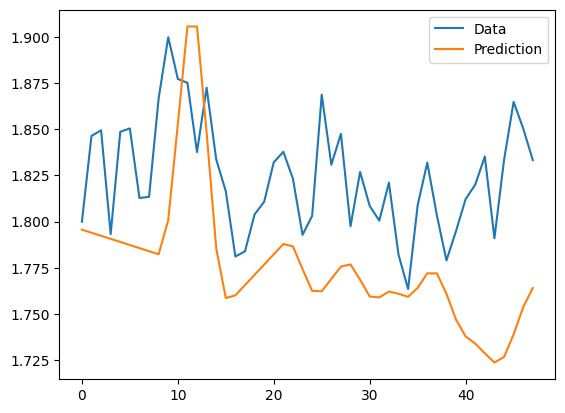

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


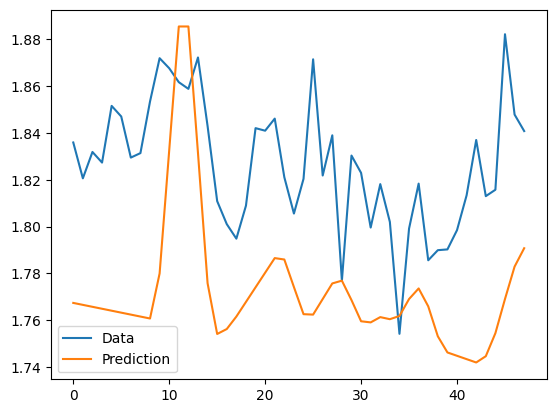

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


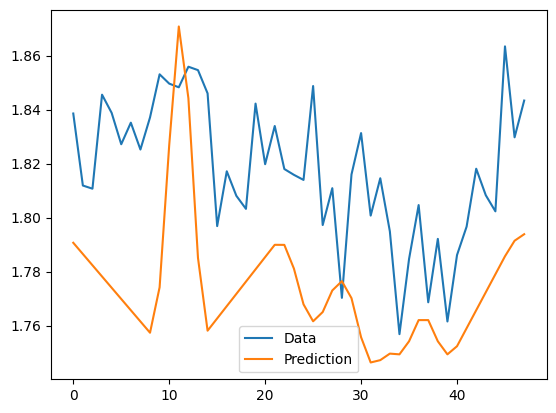

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


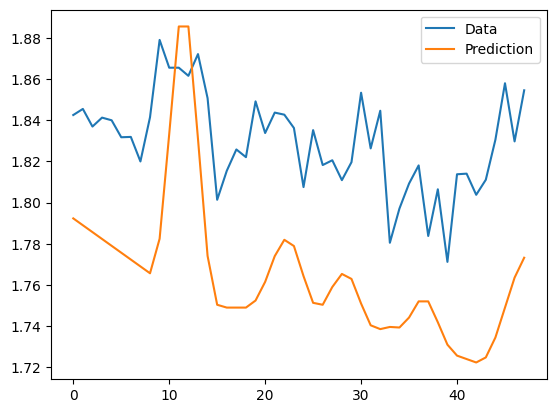

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


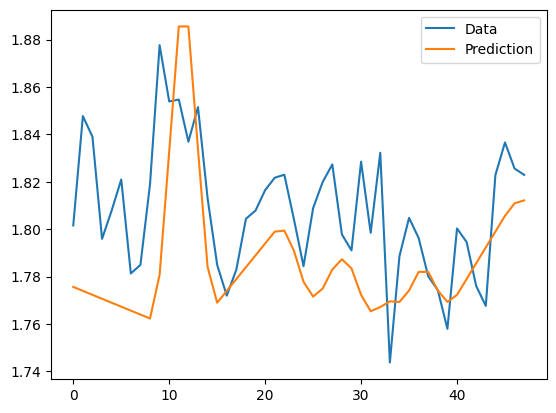

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


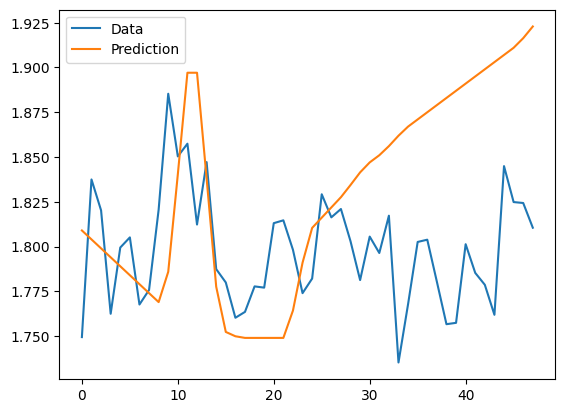

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


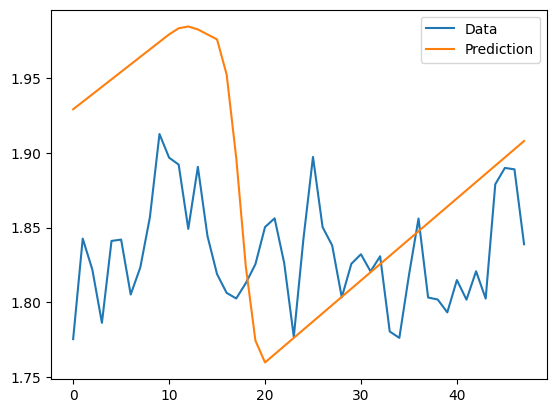

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


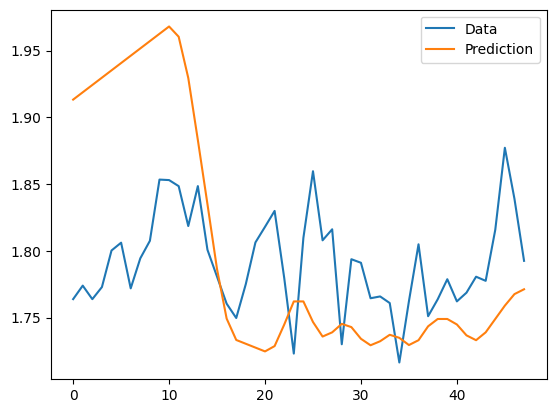

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


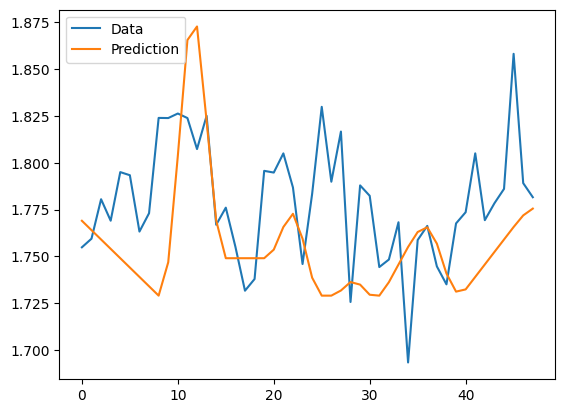

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


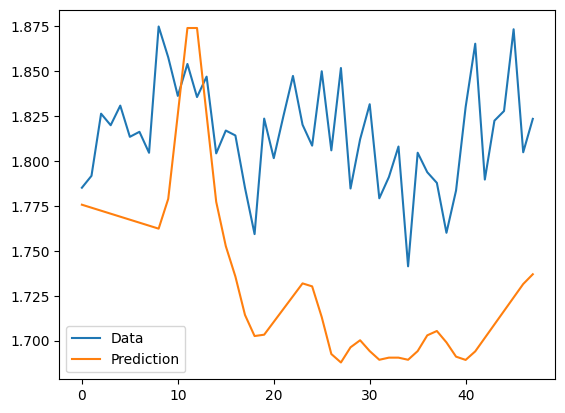

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


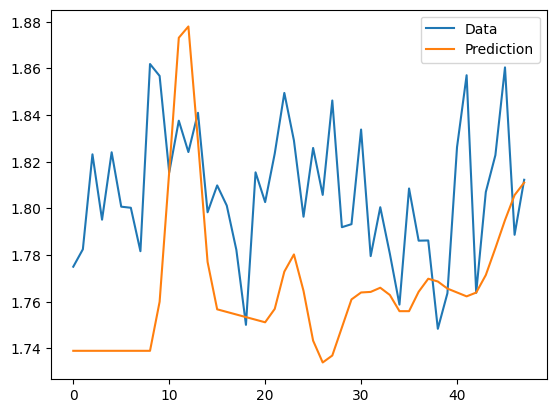

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


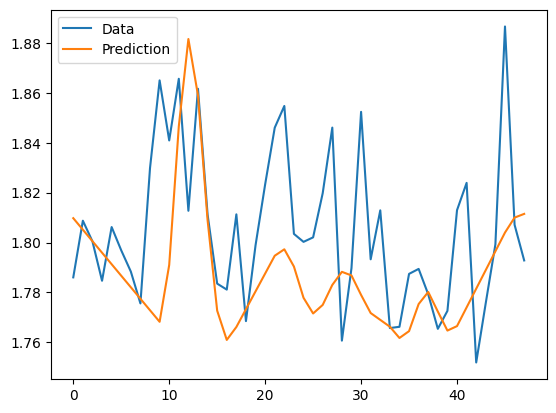

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


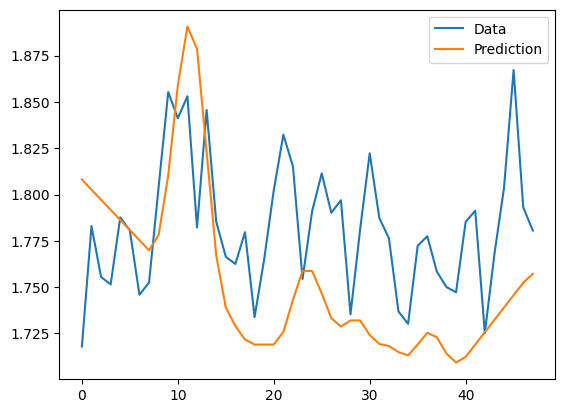

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


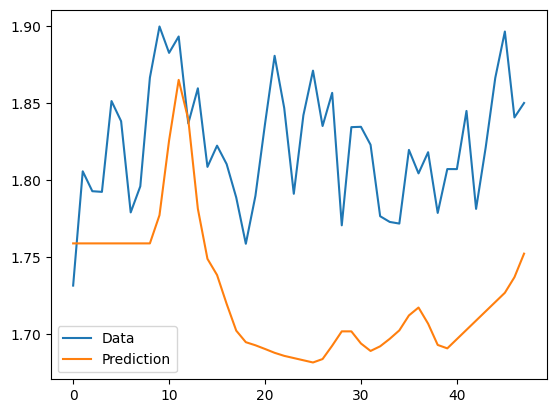

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


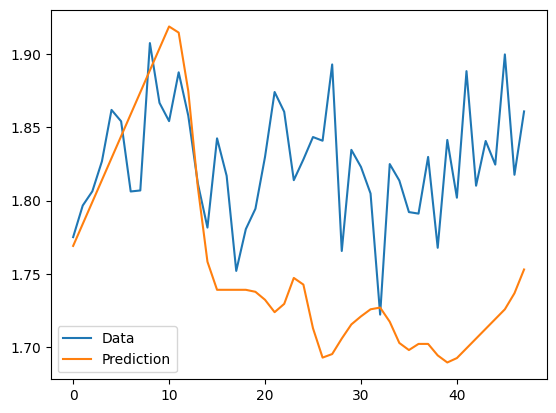

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


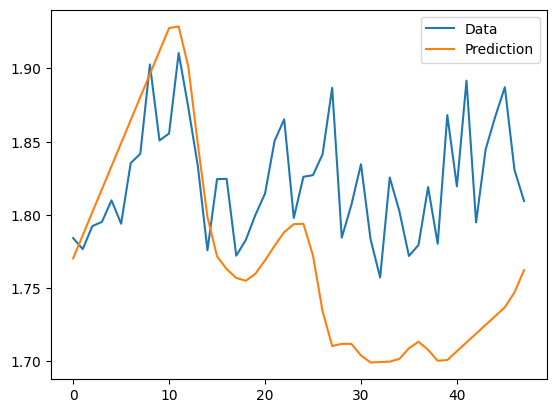

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


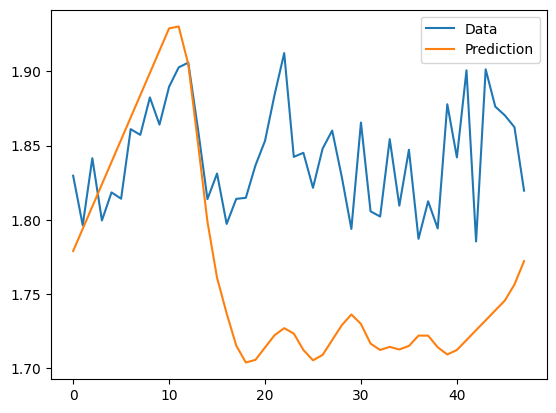

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


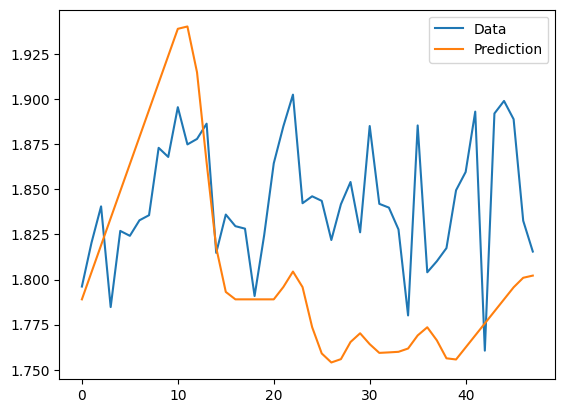

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


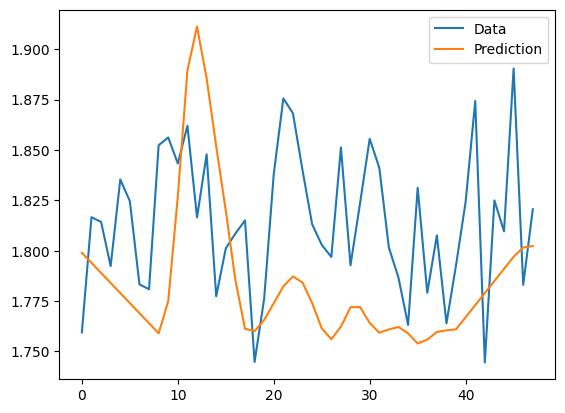

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


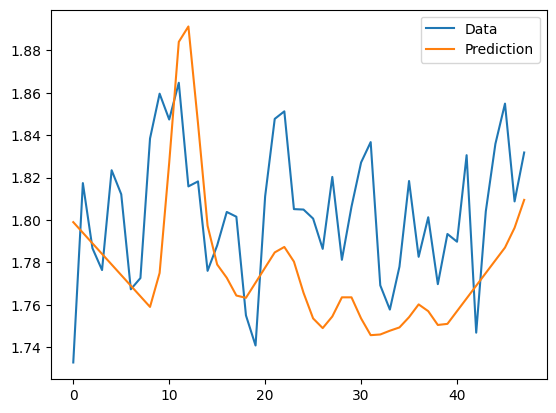

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


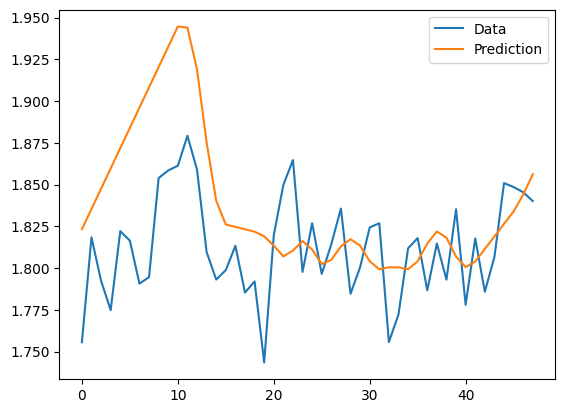

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


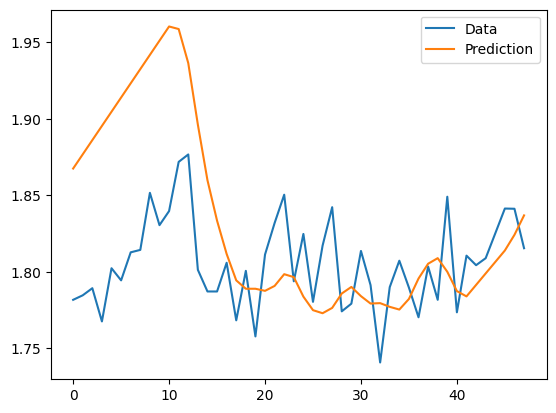

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


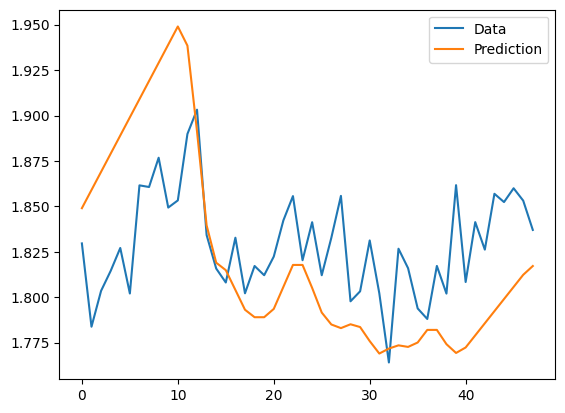

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


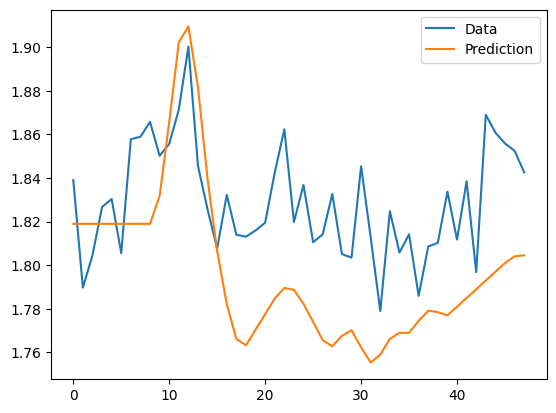

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


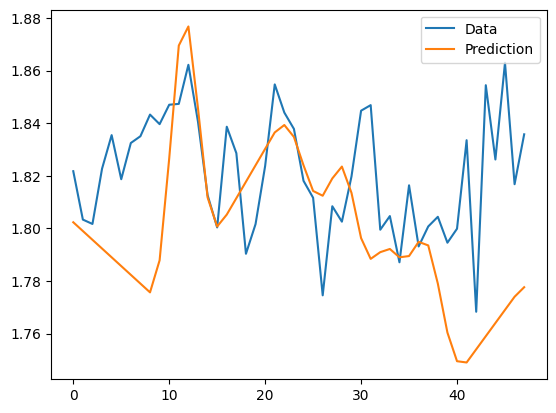

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


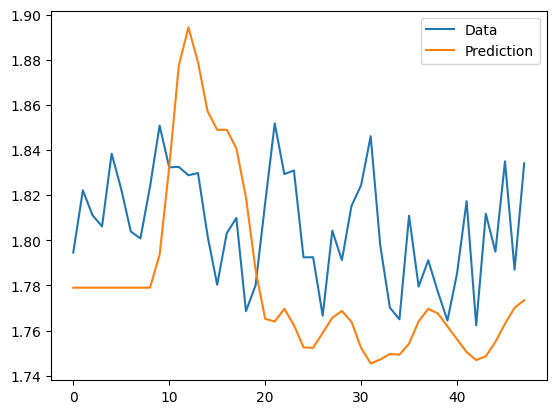

In [22]:
for idx, dataset in enumerate(X_test_splitted_data):
    prediction = model.predict(dataset.reshape(-1, 48, 9)).reshape(-1)
    y = y_test_splitted_data[idx]

    plt.plot(prediction, label='Data')
    plt.plot(y_train_splitted_data[idx], label='Prediction')
    plt.legend()

    plt.show()